<a href="https://colab.research.google.com/github/giuliocapecchi/LM-project/blob/main/lm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# %pip install torch huggingface_hub python-dotenv transformers sentence-transformers pymupdf langchain langchain-community langchain-huggingface chromadb tqdm unidecode gradio bitsandbytes

In [2]:
import os
import torch
from huggingface_hub import login
from dotenv import load_dotenv
from transformers import (
    AutoModelForCausalLM,
    AutoTokenizer,
    BitsAndBytesConfig,
)
from langchain_community.document_loaders import PyMuPDFLoader
from langchain.text_splitter import CharacterTextSplitter
import time
from tqdm import tqdm
import re
import gradio as gr
from unidecode import unidecode
import random

## Hardware requirements and constraints

Let's find out what hardware we've got available to see what kind of model(s) we'll be able to load.

> **Note:** You can also check this with the `!nvidia-smi` command.

In [ ]:
# Get GPU available memory
gpu_memory_bytes = torch.cuda.get_device_properties(0).total_memory
gpu_memory_gb = round(gpu_memory_bytes / (2**30))
print(f"Available GPU memory: {gpu_memory_gb} GB")
print(torch.cuda.get_device_name(0))

Of course, depending on the provided harware, better models can be utilized.

### Checking local GPU memory availability

Let's first analyze how we decided the model to use for this project. This notebook was primarily run and tested locally on a **laptop** with 16GB of RAM and an NVIDIA RTX 3070 laptop GPU (8GB of VRAM). The main goal was to create a pipeline that could efficiently run on this portable device, leveraging the benefits of GPUs and CUDA for AI tasks while ensuring that the performance and capabilities did not feel lacking compared to larger models.

We will need two main ingredients:
- An *embedder* model, that calculates dense embeddings from documents
- An *LLM*, that provides output given user's queries and the retrieved documents

In they're dedicated sections we will uncover the choiches made for both.

Let's now start by loading a pdf file and extracting chunks from it. These chunks' **quality** is important, since these will be essentially the *documents* on which we will compute the embeddings on.

In [ ]:
PDF_NAME = "IR Slides v1.0.pdf"


try:
    from google.colab import userdata, drive
    HF_TOKEN = userdata.get('HF_TOKEN')
    drive.mount('/content/drive')
    print("Running in Google Colab. Using userdata to get HF_TOKEN.")
    file_path = "/content/drive/MyDrive/Colab/" + PDF_NAME
except ModuleNotFoundError:
    load_dotenv()
    HF_TOKEN = os.getenv('HF_TOKEN')
    print("Not running in Google Colab. Using load_dotenv to get HF_TOKEN.")
    file_path = PDF_NAME

login(token=HF_TOKEN)

In [6]:
def preprocess_text(text):
    # Rimuovi formule matematiche LaTeX
    text = re.sub(r'\$.*?\$', '', text)
    # Rimuovi caratteri non alfanumerici eccetto punteggiatura di base
    text = re.sub(r'[^a-zA-Z0-9\s.,;:!?\'"-]', '', text)
    # Rimuovi •
    text = text.replace('•', '')
    # Normalizza i caratteri Unicode
    text = unidecode(text)
    # Rimuovi spazi multipli
    text = re.sub(r'\s+', ' ', text).strip()
    return text

def aggregate_short_documents(texts, min_length=50):
    aggregated_texts = []
    buffer = ""
    
    for doc in texts:
        if len(doc.page_content) < min_length:
            buffer += " " + doc.page_content
            buffer = buffer.strip()
        else:
            if buffer:
                doc.page_content = buffer + " " + doc.page_content
                buffer = ""
            aggregated_texts.append(doc)
    
    if buffer:
        if aggregated_texts:
            aggregated_texts[-1].page_content += " " + buffer
        else:
            aggregated_texts.append(buffer)
    
    return aggregated_texts

# ------------------------------------------------------------------------- #

# Load and process the PDF
loader = PyMuPDFLoader(file_path=file_path)
documents = loader.load()

# Split the documents into chunks
text_splitter = CharacterTextSplitter(chunk_size=1000, chunk_overlap=200, separator="\n")
texts = text_splitter.split_documents(documents)

# Preprocess the text
for doc in texts:
    doc.page_content = preprocess_text(doc.page_content)

# Aggrega i documenti corti
corpus = aggregate_short_documents(texts)

Let's give a look to some random documents extracted and preprocessed from the initial pdf 

In [ ]:
random.seed(42)
for i in range(5):
    doc = random.choice(corpus)
    doc_index = corpus.index(doc)
    print(f"DocId: {doc_index}, {doc.page_content[:100]}...")

In [ ]:
print(f"Average document length: {sum(len(doc.page_content) for doc in corpus) / len(corpus)}")

In [9]:
import os

def save_documents(documents):
    if not os.path.exists("vector_store"):
        os.makedirs("vector_store")
    # delete all files in the vector_store directory
    for file in os.listdir("vector_store"):
        os.remove(os.path.join("vector_store", file))
    for i, doc in enumerate(documents):
        with open(f"vector_store/document_{i}.txt", "w", encoding="utf-8") as f:
            f.write(doc.page_content)

save_documents(corpus)

In [ ]:
print(f"Saved {len(corpus)} documents in the vector_store directory.")

In [ ]:
import json

def extract_questions(file_path):
    with open(file_path, 'r') as file:
        data = json.load(file)
    questions = []
    for item in data:
        # q = item.get("question", "")
        # a = item.get("answers", "")
        # # 'a' è una lista di stringhe, aggiungi ad ognuno 1, 2, 3, 4
        # for i in range(len(a)):
        #     a[i] = f"{(1 + i)}) {a[i]}"
        # a = " ".join(a)
        # qplusa = f"{q} {a}"
        if str(item.get("category", "")) == "1":
            continue
        question = {
            "question": item.get("question", "").strip(),
            # "answers": item.get("answers", ""),
            # "correct": item.get("correct", ""),
            # "category": item.get("category", ""),
            # "question_id": item.get("question_id", "")
        }
        questions.append(question)
    return questions


queries = extract_questions('quiz/quiz.json')
print(f"Loaded {len(queries)} questions.")

random.seed(4242)
print(random.choice(queries))

# 1. Gather dataset embeddings
- CDE works by first getting a set of embeddings from corpus documents that is intended to be representative of the overall corpus. We first sample a number of documents from the corpus (this model is trained with 512 documents from each context) and get their embeddings from our first-stage model.
- Now that we have obtained "dataset embeddings" we can embed documents and queries like normal. Remember to use the document prompt for documents:

model card : https://huggingface.co/jxm/cde-small-v1

![cde-small-v1.png](./assets/cde-small-v1.png)

In [ ]:
from sentence_transformers import SentenceTransformer

# with sentence-transformers we don't need prefixes but, to do retrieval, we need to use prompt_name="query" and prompt_name="document" in the encode method of the model when embedding queries and documents, respectively.
device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using device: {device}")

# Load the embeddings model
embeddings_model = SentenceTransformer("jxm/cde-small-v1", trust_remote_code=True).to(device)

In [ ]:
minicorpus_size = embeddings_model[0].config.transductive_corpus_size # 512
minicorpus_docs = random.choices(corpus, k=minicorpus_size) # oversampling is okay
assert len(minicorpus_docs) == minicorpus_size # You must use exactly this many documents in the minicorpus. You can oversample if your corpus is smaller.

dataset_embeddings = embeddings_model.encode(
    [doc.page_content for doc in minicorpus_docs],
    prompt_name="document",
    convert_to_tensor=True,
    show_progress_bar=True
)

print(f"Corpus size: {len(corpus)}")
print(f"Computed embeddings for {len(minicorpus_docs)} documents. Shape: {dataset_embeddings.shape}")

In [ ]:
print("Some mini-corpus documents:")

# get some random documents from the minicorpus
random.seed(4242)
for i in random.sample(range(minicorpus_size), 5):
    print(f"document {i}: {minicorpus_docs[i].page_content[:100]}...")

# 2. Get doc embeddings

In [ ]:
doc_embeddings = embeddings_model.encode(
    [doc.page_content for doc in corpus],
    prompt_name="document",
    dataset_embeddings=dataset_embeddings, # this is the contexualized embeddings of the minicorpus
    convert_to_tensor=True,
    show_progress_bar=True
)

query_embeddings = embeddings_model.encode(
    [query['question'] for query in queries],
    prompt_name="query",
    dataset_embeddings=dataset_embeddings,  # this is the contexualized embeddings of the minicorpus
    convert_to_tensor=True,
    show_progress_bar=True
)

print(f"Document embeddings shape: {doc_embeddings.shape}")
print(f"Query embeddings shape: {query_embeddings.shape}")

In [ ]:
similarities = embeddings_model.similarity(query_embeddings, doc_embeddings)
print("'similarities' shape : ",similarities.shape)
topk_values, topk_indices = similarities.topk(5)

random.seed(4242)
random_queries = random.sample(queries, 2)
for query in random_queries:
    query_idx = queries.index(query)
    print(f"Query: {query['question']}")
    for j, idx in enumerate(topk_indices[query_idx]):
        doc = corpus[idx]
        print(f"Rank {j+1} (Score: {topk_values[query_idx][j]:.4f}, Doc ID: {idx}): {doc.page_content[:200]}...")
    print()


# 3. Chroma

In [ ]:
from chromadb import Client, Collection

# Initialize the Chroma client
client = Client()

COLLECTION_NAME = "chroma-collection"

# Check if the collection exists and delete it if it does
if COLLECTION_NAME in [col.name for col in client.list_collections()]:
    client.delete_collection(name=COLLECTION_NAME)
    print(f"Collection {COLLECTION_NAME} exists, deleting it")
else:
    print(f"Collection {COLLECTION_NAME} does not exist")

In [18]:
from chromadb import Documents, EmbeddingFunction, Embeddings

class CustomEmbeddingFunction(EmbeddingFunction):
    def __init__(self, mode="document"):
        self.mode = mode  # "document" or "query"
        
    def __call__(self, input: Documents) -> Embeddings:

        # se input è una lista di documenti, estrai il testo
        if isinstance(input, list):
            input = [doc if isinstance(doc, str) else doc.page_content for doc in input]
        
        # Genera embeddings usando il modello specifico
        embeddings = embeddings_model.encode(
            input,
            prompt_name=self.mode,
            dataset_embeddings=dataset_embeddings,
            convert_to_tensor=True,
            show_progress_bar=True
        ).cpu().numpy()
        
        return embeddings.tolist()

# Create an instance of the embeddings function for queries (we already calculated all the embeddings of the documents)
query_embeddings_function = CustomEmbeddingFunction(mode="query")

# Create a Chroma collection with the custom embedding function
collection: Collection = client.create_collection(
    name=COLLECTION_NAME,
    embedding_function=query_embeddings_function,
    get_or_create=True,
    metadata={"hnsw:space": "cosine"} # l2 is the default but cosine is more suitable for this embedding function
)

# Add the documents and their (already computed) embeddings to the collection
collection.add(
    ids=[str(i) for i in range(len(corpus))],  # Unique identifiers for the documents
    embeddings=doc_embeddings.cpu().numpy(),
    documents=[doc.page_content for doc in corpus],
)

In [ ]:
#print(collection.peek()) # returns a list of the first 10 items in the collection
print(collection.count()) # returns the number of items in the collection

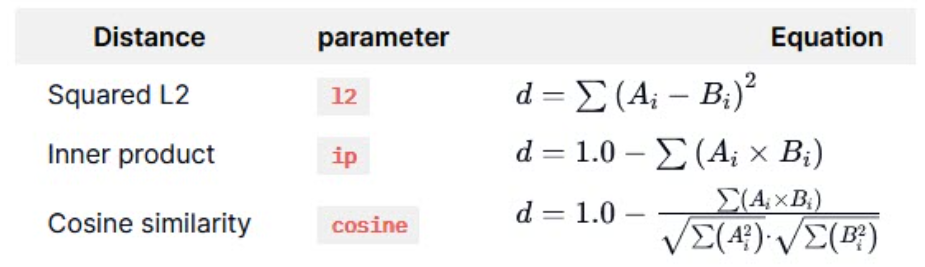

In [ ]:
query_text = "How many bytes can UTF-8 use to encode a character?"

results = collection.query(
    query_texts=query_text,
    n_results=5
)
print(results)

# Print the results with the document IDs and scores
for i, (doc_id, score, doc) in enumerate(zip(results['ids'][0], results['distances'][0], results['documents'][0])):
    print(f"Rank {i+1}: Document ID: {doc_id}, Score: {1-score:.4f}, {doc[:200]}")

# 3. Compute scores between queries and documents

In [ ]:
from seaborn import heatmap
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Plot heatmap
heatmap(similarities.cpu().numpy().T, cmap="jet", ax=axes[0])
axes[0].set_title("Similarity Heatmap")

# Plot histogram
axes[1].hist(similarities.cpu().flatten(), bins=50, color='blue', alpha=0.6)
axes[1].set_title("Distribution of Similarity Scores")
axes[1].set_xlabel("Similarity")
axes[1].set_ylabel("Frequency")
axes[1].axvline(x=0.5, color='red', alpha=0.6, linestyle='--')

plt.tight_layout()
plt.show()

# LLM

After conducting some research, we chose to work with one of Meta's latest smaller open-source Llama models available at the time of writing this notebook: [Llama-3.2-3B-Instruct](https://huggingface.co/meta-llama/Llama-3.2-3B-Instruct), released the *25th of September 2024*. We specifically selected the *instruct* variant because it is pre-trained to follow basic instructions, offering a more user-friendly and fine-tuned experience compared to the standard non-instruct version (which is also available). Below, we review this model's [specifications](https://llamaimodel.com/requirements-3-2/):

| **Llama 3.2 3B Instruct Model Specifications**                    | **Requirement**       | **Details**                                                                                  |
|----------------------------------|-----------------------|----------------------------------------------------------------------------------------------|
| Parameters                       | 3 billion             |                                                                                              |
| Context Length                   | 128,000 tokens        |                                                                                              |
| **Hardware Requirements**        |                       |                                                                                              |
| CPU and RAM                      |                       | CPU: Multicore processor <br> RAM: Minimum of 16 GB recommended                              |
| GPU                              |                       | NVIDIA RTX series (for optimal performance), at least 8 GB VRAM                              |
| **Estimated GPU Memory Requirements** |                       |                                                                                              |
| Higher Precision Modes           | BF16/FP16             | ~6.5 GB                                                                                      |
| Lower Precision Modes            | FP8                   | ~3.2 GB                                                                                      |
|                                  | INT4                  | ~1.75 GB                                                                                     |
| **Software Requirements**        |                       |                                                                                              |
| Software Dependencies            |                       | Frameworks: PyTorch <br> Libraries: Hugging Face Transformers (version 4.45.0 or higher), CUDA |

In [ ]:
print("Is bf16 supported: ",torch.cuda.is_bf16_supported())

The `bitsandbytes` library is a lightweight Python wrapper around CUDA custom functions, in particular 8-bit optimizers, matrix multiplication (LLM.int8()), and 8 & 4-bit quantization functions.

The library includes quantization primitives for 8-bit & 4-bit operations, through `bitsandbytes.nn.Linear8bitLt` and `bitsandbytes.nn.Linear4bit` and 8-bit optimizers through bitsandbytes.optim module.

#### Quantization Choices

We chose a *middle ground* by loading the model with **4-bit quantization** while maintaining **BFloat16** precision for computation.

The use of 4-bit quantization reduces the precision of the model’s weights to just 4 bits per value, significantly lowering memory usage and accelerating inference. This method retains only the most essential information, sacrificing some numerical precision, but allows for larger models to be handled on GPUs with limited memory. Despite the weights being quantized to 4 bits, the model still performs computations in **16-bit floating point (BFloat16)** precision. BFloat16 is a 16-bit format that preserves much of the dynamic range of floating-point operations while requiring less memory than the traditional 32-bit format. This way, while the 4-bit quantization reduces the memory footprint of the model weights, the computation is performed in BFloat16, optimizing performance on modern GPUs that are tailored for BFloat16 operations. This configuration strikes a balance between computational efficiency and numerical precision, enabling fast inferences with minimal memory usage without significant loss in result quality.

Given the hardware constraints, we opted for **4-bit quantization** using `BitsAndBytes` (as explained later). This approach greatly reduces the memory footprint and speeds up inference, ensuring acceptable performance for our use case. Without this configuration, the GPU’s memory usage was consistently at 100%, and inference times were approximately 2-3 minutes per query. With 4-bit quantization, memory usage drops to about 6GB, preventing GPU overload and reducing inference time to around 30 seconds per query, delivering satisfactory results. Further details on the quantization process will be provided later.

However, we also need to consider that both the embedding model and the LLM must be loaded into memory, which adds another layer of complexity to the memory management. This requires careful balancing, as the total memory usage must accommodate both the LLM and the embedding model simultaneously. We will address how we manage this in the next section.

In [ ]:
# os.environ["CUDA_VISIBLE_DEVICES"] = "0"  # TODO : riguardare che fa

MODEL_NAME = "meta-llama/Llama-3.2-3B-Instruct"

# Quantization is a technique that reduces the precision of
# the model’s weights to make it run faster and consume less memory,
# often at the cost of a slight reduction in model accuracy or quality
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,                      # Lower precision reduces memory usage and can speed up inference (maybe try 8)
    bnb_4bit_use_double_quant=True,         # Using double quantization can help reduce the loss in accuracy associated with quantization
    bnb_4bit_quant_type="nf4",              # Normal Float 4-bit quantization, a scheme that may preserve model quality better than straightforward quantization methods
    bnb_4bit_compute_dtype=torch.bfloat16,  # The internal compute dtype used during inference. bfloat16 (BF16) is often chosen because it’s efficient on modern accelerators
    llm_int8_enable_fp32_cpu_offload=True   # Enable FP32 CPU offload
)


llm_model = AutoModelForCausalLM.from_pretrained(
    MODEL_NAME,
    device_map={"": device},  # Custom device map to ensure all modules are on GPU
    quantization_config=bnb_config,
).to(device)

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
tokenizer.pad_token = tokenizer.eos_token

generation_config = llm_model.generation_config
generation_config.max_new_tokens = 200                    # the maximum number of new tokens the model will generate (long outputs might be more prone to off-topic or repetitive content)
generation_config.min_new_tokens = 1                      # the minimum number of new tokens the model will generate
generation_config.temperature = 0.1                       # it controls the randomness of the generation, lower temp means more deterministic, conservative (less creative) and repetitive answers [about 0.1-1.2]
generation_config.top_p = 0.5                             # nucleus sampling controls how the model picks words based on their cumulative probability, lower value (0.5) means safer, more coherent text but less diverse [about 0.5-0.9]
generation_config.num_return_sequences = 1                # how many separate output sequences are returned for each generation prompt, get multiple different answers in one go, useful for picking the best response from several tries
generation_config.pad_token_id = tokenizer.eos_token_id   # special token IDs that represent padding and the end-of-sequence token. Generally, these are set to ensure the model knows when to stop and how to handle inputs of different lengths
generation_config.eos_token_id = tokenizer.eos_token_id
generation_config.repetition_penalty = 2.0                # discourages the model from repeating the same phrases or tokens over and over [about 1.0-2.0] (high value cause the model to avoid some tokens even if they are contextually appropriate)

In [ ]:
# Check GPU usage
gpu_memory_gb = torch.cuda.get_device_properties(device).total_memory / (1024 ** 3)  # in GB
memory_allocated_gb = torch.cuda.memory_allocated(device) / (1024 ** 3)  # in GB
print(f"Memory Allocated: {memory_allocated_gb:.2f} GB")
print(f"Total memory usage: {(memory_allocated_gb / gpu_memory_gb) * 100:.2f}%")

In [ ]:
def retrieve_relevant_documents(query, k=5):
    results = collection.query( # query the Chroma collection
        query_texts=query,
        n_results=k
    )
    return results['documents'][0], results['distances'][0]

# test the function
query = "How many bytes can UTF-8 use to encode a character?"
print(f"Query: {query}")
documents, distances = retrieve_relevant_documents(query)
for doc, distance in (zip(documents, distances)):
    print(f"(score: {1-distance:.4f}) {doc[:200]}")

In [41]:
base_prompt = """You are an AI assistant for RAG. Your task is to understand the user question, and provide an answer using the provided contexts.

Your answers are correct, high-quality, and written by a domain expert. If the provided context does not contain the answer, simply state, "The provided context does not have the answer."

User question: {user_query}

Contexts:
{chunks_information}

Answer:
"""

In [42]:
# Example usage of the RAG system with the PDF
def answer_questions(questions):
    count = 0
    error = 0
    results = {}

    current_time = time.strftime("%m%d-%H%M%S")

    pbar = tqdm(questions, total=len(questions), desc="Answering questions...", unit="question")
    for q in pbar:
        top_k_chunks = retrieve_relevant_documents(q['question'], k=5)
        retrieved_chunks = [chunk for chunk in top_k_chunks]
        prompt = base_prompt.format(user_query=q['question'], chunks_information="\n".join(retrieved_chunks))
        encoding = tokenizer(prompt, return_tensors="pt").to(device)
        with torch.inference_mode():
            outputs = llm_model.generate(
                input_ids=encoding.input_ids,
                attention_mask=encoding.attention_mask,
                generation_config=generation_config,
                num_beams=5,  # Use beam search for better results
                early_stopping=True,  # Stop early if all beams finish
            )

        # Exclude the prompt tokens from the generated output
        generated_tokens = outputs[0][len(encoding.input_ids[0]):]
        generated_unpreprocessed_sequence = tokenizer.decode(generated_tokens, skip_special_tokens=True).strip()
        match = re.search(r'\b[1-4]\b', generated_unpreprocessed_sequence)
        answer = match.group(0) if match else ""  # first number found or empty string

        with open(f"quiz/runs_basemodel/quiz_answers_{current_time}.txt", "a", encoding="utf-8") as f:
            f.write(f"Question: {q['question']}\nAnswer: {answer}\nCorrect answer:{q['correct']}\nGenerated unpreprocessed sequence: {generated_unpreprocessed_sequence}\n--------------------------------------------------------------------\n\n")

        results[q['question_id']] = answer

        if len(answer) != 1 or answer not in "1234":
            error += 1
        else:  # the format is correct, now check if the answer is correct
            if str(q['correct']) == answer:
                count += 1
        pbar.set_postfix(Corrects=f"{count}/{len(questions)}", Errors=error)

    print("-------------------------\tFINISHED RUN. Error count: ", error, "-------------------------")
    return results, count / len(questions) * 100

In [ ]:
def query_rag_model(user_query):
    documents, distances = retrieve_relevant_documents(user_query, k=5) # retrieve the top 5 most relevant documents
    print(f"Number of retrieved documents: {len(documents)}")    
    # Print the results
    for doc, distance in zip(documents, distances):
        print(f"(score: {1-distance:.4f}) {doc[:200]}")
    prompt = base_prompt.format(user_query=user_query, chunks_information="\n".join(documents))
    encoding = tokenizer(prompt, return_tensors="pt").to(device)
    with torch.inference_mode():
        outputs = llm_model.generate(
            input_ids=encoding.input_ids,
            attention_mask=encoding.attention_mask,
            generation_config=generation_config,
            num_beams=5,
            early_stopping=True,
        )
    generated_tokens = outputs[0][len(encoding.input_ids[0]):]
    generated_unpreprocessed_sequence = tokenizer.decode(generated_tokens, skip_special_tokens=True).strip()
    print(f"Generated sequence: {generated_unpreprocessed_sequence}")
    return generated_unpreprocessed_sequence

iface = gr.Interface(
    fn=query_rag_model,
    inputs="text",
    outputs="text",
    title="RAG Model Query Interface",
    description="Ask questions to the RAG model and get answers based on the provided PDF context."
)

iface.launch()